In [ ]:
'''
导入所需库
'''
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
'''
计算 benchmark （2-12 mom, str, wstr）
'''

df = pd.read_feather('test_data.feather')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['id', 'date']).reset_index(drop=True)

def calculate_2_12_mom(group):
    # 按股票分组计算
    group = group.sort_values('date')
    
    # 定义时间窗口参数（假设每月21个交易日）
    lookback = 252  # 12个月（252天）
    exclude = 42     # 2个月（42天）
    window = lookback - exclude  # 实际计算窗口：210天
    
    # 计算过去12个月（t-252至t-42）的累计收益
    group['mom_2_12'] = (
        group['ret']
        .shift(exclude)            # 排除最近42天
        .rolling(window=window, min_periods=1)  # 允许最小1天计算
        .apply(lambda x: (1 + x).prod() - 1)
    )
    return group
df = df.groupby('id', group_keys=False).apply(calculate_2_12_mom)

df['str'] = (
    df.groupby('id')['ret']
    .transform(lambda x: x.rolling(21).apply(lambda r: (1 + r).prod() - 1))
)

df['wstr'] = (
    df.groupby('id')['ret']
    .transform(lambda x: x.rolling(5).apply(lambda r: (1 + r).prod() - 1))
)
df

In [ ]:
'''
计算 benchmark （trend）
'''
# ------------- 1. 读取并预处理日度数据  -----------------
# df = pd.read_csv("your_data.csv", parse_dates=["date"])
df["date"] = pd.to_datetime(df["date"])
df.sort_values(["id", "date"], inplace=True)

# ------------- 2. 计算多窗口标准化移动平均 tildeA --------------
window_list = [5,20,60]
for L in window_list:
    sma_col = f"SMA_{L}"
    tilde_col = f"tildeA_{L}"
    df[sma_col] = (
        df.groupby("id")["close"]
          .transform(lambda x: x.rolling(window=L, min_periods=L).mean())
    )
    df[tilde_col] = df[sma_col] / df["close"]

# ------------- 3. 每日跨截面回归，估计 β_d ---------------------
beta_list = []
tilde_cols = [f"tildeA_{L}" for L in window_list]

for cur_date, grp in df.dropna(subset=tilde_cols + ["ret_20d"]).groupby("date"):
    # 自变量矩阵：tildeA_*，并加截距
    X = grp[tilde_cols]
    X = sm.add_constant(X)
    y = grp["ret_20d"]
    res = sm.OLS(y, X).fit()

    # 只提取 tildeA_* 对应的系数（如果某天恰好没有截距也不用管）
    beta_vals = res.params.filter(items=tilde_cols)
    # 确保顺序一致，缺失用 NaN 填充
    beta_vals = beta_vals.reindex(tilde_cols)
    beta_vals.name = cur_date
    beta_list.append(beta_vals)

betas_df = pd.DataFrame(beta_list)  # index: date；columns: tildeA_{L}

# ------------- 4. 平滑 β（可选：减少噪声） & 向后移一日避免看未来 --------------
# 这里用过去 12 天简单均值，你也可以换成别的周期
betas_smooth = betas_df.rolling(window=12, min_periods=1).mean().shift(1)

# ------------- 6. 将 β 合并回原始 df，并计算 daily trend --------------
# 重命名 β 列，避免和 tildeA 列冲突
beta_cols_map = {f"tildeA_{L}": f"beta_{L}" for L in window_list}
betas_smooth = (
    betas_smooth
    .rename(columns=beta_cols_map)
    .reset_index()
    .rename(columns={"index": "date"})
)

# 把 beta 合并到 df
df = df.merge(betas_smooth, on="date", how="left")

# 用点积计算 daily trend
df["trend"] = 0.0
for L in window_list:
    df["trend"] += df[f"tildeA_{L}"] * df[f"beta_{L}"]

drop_cols = [f"SMA_{L}" for L in window_list] + list(beta_cols_map.values())
df.drop(columns=drop_cols, inplace=True)
df= df.sort_values(["id", "date"]).reset_index(drop=True)
df

In [ ]:
'''
筛选交易日
'''

anchor_df = pd.read_feather('./data/trading_days_anchor_2001_2019.feather')
anchor_df['date'] = pd.to_datetime(anchor_df['date']).dt.date
anchor_dates = anchor_df.loc[anchor_df['anchor_5'] == 1.0, 'date']

df = (
    df
    .groupby('id', group_keys=False)
    .apply(lambda grp: grp[grp['date'].isin(anchor_dates)])
    .reset_index(drop=True)
)
df = df.sort_values(['id', 'date']).reset_index(drop=True)
df.to_feather('./data/benchmark.feather')
df

In [ ]:
'''
benchmark （2-12 mom, str, wstr, trend）10分位累计收益图
'''
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df = pd.read_feather('test_data.feather')
spy_data_path = 'SPY.csv'
df['date'] = pd.to_datetime(df['date'])
spy = pd.read_csv(spy_data_path, parse_dates=['Date']).rename(columns={'Date': 'date'})

# 2. Compute SPY daily log returns and its volatility over the sample
spy['log_ret'] = np.log(spy['Close'] / spy['Close'].shift(1))
spy_vol = spy['log_ret'].std()

# 3. Define a helper to assign deciles (reverse for reversal signals)
def assign_decile(group, signal_col, reverse=False):
    # Multiply by -1 for reverse rankings
    vals = -group[signal_col] if reverse else group[signal_col]
    return pd.qcut(vals.rank(method='first'), 10, labels=False) + 1

# 4. Assign deciles for each signal by date
df['dec_mom'] = df.groupby('date').apply(lambda g: assign_decile(g, 'mom_2_12', reverse=False)).droplevel(0)
df['dec_str'] = df.groupby('date').apply(lambda g: assign_decile(g, 'str', reverse=True)).droplevel(0)
df['dec_wstr'] = df.groupby('date').apply(lambda g: assign_decile(g, 'wstr', reverse=True)).droplevel(0)
df['dec_trend'] = df.groupby('date').apply(lambda g: assign_decile(g, 'trend', reverse=True)).droplevel(0)

# 5. Compute daily long-short returns for each strategy
rets = pd.DataFrame(index=sorted(df['date'].unique()))
for dec_col, name in [('dec_mom', 'Momentum'),
                      ('dec_str', '1M_Reversal'),
                      ('dec_wstr', '1W_Reversal'),
                      ('dec_trend', 'Trend')]:
    top = df[df[dec_col] == 10].groupby('date')['ret_5d'].mean()
    bottom = df[df[dec_col] == 1].groupby('date')['ret_5d'].mean()
    rets[name] = top - bottom

# 6. Scale each strategy to SPY volatility
for col in rets.columns:
    strat_vol = rets[col].std()
    rets[col] = rets[col] * (spy_vol / strat_vol)

# 7. Compute log returns and cumulative log returns
log_rets = np.log(1 + rets)
cum_log_rets = log_rets.cumsum()

# 8. Plot cumulative volatility-adjusted log returns
plt.figure(figsize=(12, 6))
for col in cum_log_rets.columns:image_labels_5
    plt.plot(cum_log_rets.index, cum_log_rets[col], label=col)

plt.title('Cumulative Volatility-Adjusted Log Returns of Equal-Weighted Long-Short Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''
整理 CNN 训练结果数据
'''
df_test = pd.read_feather('./data/test_data.feather')[['id', 'date', 'ret', 'ret_5d']]

def prepare_df(label_path, drop_cols):
    """
    读取 labels 文件，删掉不需要的列，
    再和 df_test 按 id/date 左连接，最后排序并重置索引
    """
    df = pd.read_feather(label_path)
    df = df.drop(columns=drop_cols)
    df = df.merge(df_test, on=['id', 'date'], how='left')
    df = df.sort_values(by=['id', 'date']).reset_index(drop=True)
    return df

drops = {
    5:  ['image_path', 'label_5',  'label_20', 'label_60', 'pre_label_5',  'pre_label_20', 'pre_label_60'],
    20: ['image_path', 'label_5',  'label_20', 'label_60', 'pre_label_5'],
    60: ['image_path', 'label_5',  'label_20', 'label_60', 'pre_label_5'],
}

df5  = prepare_df('./labels_test/image_labels_i5.feather',  drops[5])
df20 = prepare_df('./labels_test/image_labels_i20.feather', drops[20])
df60 = prepare_df('./labels_test/image_labels_i60.feather', drops[60])

/tmp/ipykernel_3047380/3726866962.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['dec_I5']   = df.groupby('date').apply(lambda g: assign_decile(g, '5_5_prob_1')).droplevel(0)
/tmp/ipykernel_3047380/3726866962.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['dec_mom']  = df.groupby('date').apply(lambda g: assign_decile(g, 'mom_2_12')).droplevel(0)
/tmp/ipykernel_3047380/3726866962.py:34: Dep

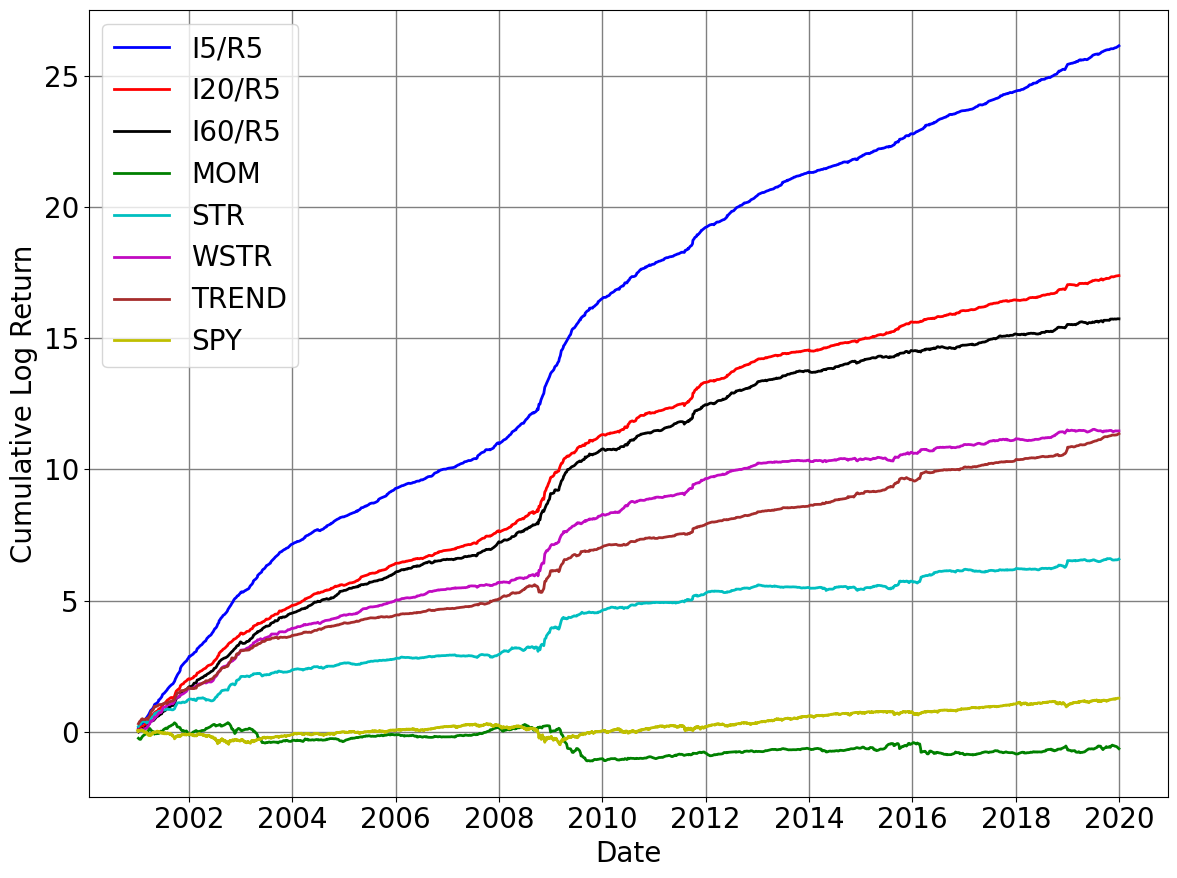

In [ ]:
'''
10分位累计收益图
'''

df = pd.read_feather('./data/benchmark.feather')
df['date'] = pd.to_datetime(df['date'])

df20 = df_merged_20.copy()
df20['date'] = pd.to_datetime(df20['date'])

df60 = df_merged_60.copy()
df60['date'] = pd.to_datetime(df60['date'])
spy = pd.read_csv(spy_data_path, parse_dates=['Date']).rename(columns={'Date': 'date'})

# —— 2. 计算 SPY 的日对数收益及全样本波动率 —— #
spy['log_ret'] = np.log(spy['Close'] / spy['Close'].shift(1))
spy_vol = spy['log_ret'].std()

# —— 3. 定义打分函数 —— #
def assign_decile(group, signal_col, reverse=False):
    vals = -group[signal_col] if reverse else group[signal_col]
    return pd.qcut(vals.rank(method='first'), 10, labels=False) + 1

# —— 4. 在各自表上做分位数 —— #
# 4.1 主策略（I5、MOM、STR、WSTR）在 df 上
df['dec_I5']   = df.groupby('date').apply(lambda g: assign_decile(g, '5_5_prob_1')).droplevel(0)
df['dec_mom']  = df.groupby('date').apply(lambda g: assign_decile(g, 'mom_2_12')).droplevel(0)
df['dec_str']  = df.groupby('date').apply(lambda g: assign_decile(g, 'str', reverse=True)).droplevel(0)
df['dec_wstr'] = df.groupby('date').apply(lambda g: assign_decile(g, 'wstr', reverse=True)).droplevel(0)
df['dec_tr'] = df.groupby('date').apply(lambda g: assign_decile(g, 'trend')).droplevel(0)

# 4.2 I20 在 df20 上
df20['dec_I20'] = df20.groupby('date').apply(lambda g: assign_decile(g, '5_prob_1')).droplevel(0)
# 4.3 I60 在 df60 上
df60['dec_I60'] = df60.groupby('date').apply(lambda g: assign_decile(g, '5_prob_1')).droplevel(0)

# —— 5. 分别计算各策略的 daily long–short return —— #
rets = pd.DataFrame()

# I5/R5
top  = df[df['dec_I5'] == 10].groupby('date')['ret_5d'].mean()
bot  = df[df['dec_I5'] == 1 ].groupby('date')['ret_5d'].mean()
rets['I5/R5'] = top - bot

# I20/R5 —— 用 df20 自己的日期
top20 = df20[df20['dec_I20'] == 10].groupby('date')['ret_5d'].mean()
bot20 = df20[df20['dec_I20'] == 1 ].groupby('date')['ret_5d'].mean()
rets['I20/R5'] = top20 - bot20

# I60/R5 —— 用 df60 自己的日期
top60 = df60[df60['dec_I60'] == 10].groupby('date')['ret_5d'].mean()
bot60 = df60[df60['dec_I60'] == 1 ].groupby('date')['ret_5d'].mean()
rets['I60/R5'] = top60 - bot60

# MOM
top_mom = df[df['dec_mom'] == 10].groupby('date')['ret_5d'].mean()
bot_mom = df[df['dec_mom'] == 1 ].groupby('date')['ret_5d'].mean()
rets['MOM'] = top_mom - bot_mom

# STR
top_str = df[df['dec_str'] == 10].groupby('date')['ret_5d'].mean()
bot_str = df[df['dec_str'] == 1 ].groupby('date')['ret_5d'].mean()
rets['STR'] = top_str - bot_str

# WSTR
top_wstr = df[df['dec_wstr'] == 10].groupby('date')['ret_5d'].mean()
bot_wstr = df[df['dec_wstr'] == 1 ].groupby('date')['ret_5d'].mean()
rets['WSTR'] = top_wstr - bot_wstr

top_trend = dft[dft['dec_tr'] == 10].groupby('date')['ret_5d'].mean()
bot_trend = dft[dft['dec_tr'] == 1 ].groupby('date')['ret_5d'].mean()
rets['TREND'] = top_trend - bot_trend


# —— 6. 按 SPY 波动率调节 —— #
horizon = 5
# 1. 计算 SPY 的日波动率
spy_daily_vol = spy['log_ret'].std()

# 2. 转成 5 天波动率
spy_5d_vol = spy_daily_vol * np.sqrt(horizon)

# 3. 用 spy_5d_vol 去做对齐
for col in rets.columns:
    strat_5d_vol = rets[col].std()
    rets[col] = rets[col] * (spy_5d_vol / strat_5d_vol)


# —— 7. 计算对数收益及累积对数收益 —— #
log_rets     = np.log(1 + rets)
cum_log_rets = log_rets.cumsum()


# —— 8. SPY 累积对数收益 —— #
spy = spy.set_index('date')
spy['cum_log_ret'] = spy['log_ret'].cumsum()


# —— 9. 绘图（带颜色） —— #
plt.figure(figsize=(12, 9))

# 定义各策略的颜色
colors = ['#0000ff',  # I5/R5: 蓝
          '#ff0000',  # I20/R5: 红
          '#000000',  # I60/R5: 黑
          '#008000',  # MOM: 绿
          '#00bfc0',  # STR: 青
          '#c10ac1',
          '#a62d2c']  # WSTR: 紫

for (col, c) in zip(cum_log_rets.columns, colors):
    series = cum_log_rets[col].dropna()
    plt.plot(series.index, series.values, label=col, color=c, linewidth=2)
plt.plot(spy.index, spy['cum_log_ret'], label='SPY', color='#bfbf00', linewidth=2)

# plt.title('Cumulative Volatility-Adjusted Log Returns of Equal-Weighted Long-Short Portfolios',fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Cumulative Log Return',fontsize=20)
plt.legend(prop={'size': 20})
plt.grid(True, color='gray',linewidth = 1)
plt.tight_layout()
plt.show()

In [ ]:
'''
计算 SR 和 Annual Ret
'''
# —— 参数 —— #
horizon       = 5
ann_factor    = 252 / horizon            # 年化收益 = mean(ret_5d) * ann_factor
ann_volifact  = np.sqrt(252 / horizon)   # 年化波动 = std(ret_5d) * ann_volifact

def summarize_deciles(df, dec_col, weight_col=None):
    # 1) 先算每日每个分位的组合5日收益
    if weight_col is None:
        daily = (df
                 .groupby(['date', dec_col])['ret_60d']
                 .mean()
                 .unstack(dec_col))
    else:
        daily = (df
                 .groupby(['date', dec_col])
                 .apply(lambda g: np.average(g['ret_60d'], weights=g[weight_col]))
                 .unstack(dec_col))

    # 2) 存放结果
    labels = {1:'Low', 10:'High'}
    for i in range(2,10): labels[i] = str(i)
    cols = [labels[d] for d in sorted(daily.columns)] + ['H-L']
    perf = pd.DataFrame(index=['Ret','SR'], columns=cols, dtype=float)

    # 3) 各分位年化收益和年化波动（再算Sharpe）
    for dec, name in labels.items():
        if dec not in daily.columns: 
            perf.loc[:,name] = np.nan; continue
        series = daily[dec].dropna()
        mu     = series.mean() * ann_factor
        vol    = series.std() * ann_volifact
        perf.at['Ret', name] = mu
        perf.at['SR',  name] = mu/vol

    # 4) H-L
    s_high = daily[10].dropna()
    s_low  = daily[1 ].dropna()
    hl     = s_high - s_low
    mu_hl  = hl.mean() * ann_factor
    vol_hl = hl.std()  * ann_volifact
    perf.at['Ret','H-L'] = mu_hl
    perf.at['SR', 'H-L'] = mu_hl/vol_hl

    return perf

# —— 把每条策略的表都做出来 —— #
strategies = {
    'I5/R5':  ('df',    'dec_I5'),
}

# 1) 等权
tables_eq = []
for name, (tab, deccol) in strategies.items():
    sub = locals()[tab]   # 取 df / df20 / df60
    perf = summarize_deciles(sub, deccol, weight_col=None)
    # 把每个策略的列加上一级标题
    perf.columns = pd.MultiIndex.from_product([[name], perf.columns])
    tables_eq.append(perf)

table_eq = pd.concat(tables_eq, axis=1)

# 2) 市值加权（cap）
tables_vw = []
for name, (tab, deccol) in strategies.items():
    sub = locals()[tab]
    perf = summarize_deciles(sub, deccol, weight_col='cap')
    perf.columns = pd.MultiIndex.from_product([[name], perf.columns])
    tables_vw.append(perf)

table_vw = pd.concat(tables_vw, axis=1)

# —— 最终输出 —— #
print("=== Equal Weight ===")
print(table_eq)
print("\n=== Value Weight ===")
print(table_vw)